In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from codecarbon import track_emissions, EmissionsTracker
from typing import List, Tuple, Dict, Optional, Union


import sklearn
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

from sklearn.metrics import f1_score, r2_score, accuracy_score
from sklearn.impute import KNNImputer, SimpleImputer

import warnings

warnings.filterwarnings("ignore")

np.random.seed(415915)

# Enoncé

Le but de ce TP va être de mesurer la consommation carbone du code que vous allez créer et de toutes les manipulations de données que vous allez effecuer. 
Pour cela, nous allons utiliser la librairie code carbon qui va chercher la consommation de votre CPU pour la traduire en émission carbone. Pour faire appel à cette librairie, voilà deux snippets de code qui vous le permettent: 

In [2]:
# tracker = EmissionsTracker()
# tracker.start()
# """ insert your code here """
# emissions: float = tracker.stop()


# @track_emissions(project_name='project_to_track')
# def function_to_track():
#     return """ Insert your code here """

# Feature engineering 
A partir de maintenant, nous vous proposons de partir dans de l'exploration des données chargées ci-dessous. 
Vous trouverez dans la classe CustomFeature, des fonctions vous permettant rapidement de visualiser certaines données, ainsi que le nombre de modalités pour chaque variable catégorielle. Libre à vous d'orienter votre feature engineering vers la méthode qui vous semble la plus adéquate. 

A nouveau dans la classe CustomFeature, deux méthodes ont été pré-construites vous permettant l'imputation de valeurs manquantes.   
 - Soit à travers une stratégie classique grâce au SimpleImputer
 - Soit au travers de l'algorithme des plus proches voisins avec un KNNImputer. 

Quelques pistes pour vous aiguiller : 
    Le jeu en vaut-il toujours la chandelle ? 
    Est-ce que plus compliqué veut toujours dire meilleur ? 
    Est-ce que plus simple satisfait quand même les besoins métiers ? 


Commentaire pour équipe GreenAI: 
la target est normalement le C02, j'ai volontairement modifié celle-ci pour que l'on puisse ingégrer de l'oversampling dans la pipeline de modélisation + les résultats étaient déjà "trop" bons sans fine tuning. On passerait donc d'un pb de regression à un pb de classification multi-classe en tentant de prédire le type de carrosserie de voiture (ie Monospace, Minibus, coupé, break.. )



# Modelisation 

Vous avez maintenant terminé votre feature engineering, ou du moins entamé une première version. Vous aviez des convictions sur la performance de certaines méthodes de Data Science, ous avez maintenant développé quelques convictions sur les émissions de celles-ci. 

Pour aller plus loin, appliquons les questions que nous nous sommes posées dans la partie Feature Engineering et tentons d'en tirer des conclusions sur le choix de modèle à utiliser, et sur la manière de l'entraîner. 

Deux algorithmes de l'état de l'art vous sont proposés, à savoir la régression logistique et le LightGBM, tous deux assez reputés pour leur faible consommation. 

Nous vous proposons de commencer par tenter des simulations d'entraînement à partir de ces deux modèles pour ensuite tester un ou deux modèles réputés plus performants mais aussi plus gourmands en ressources (@Camille c'est ici qu'on peut inclure ton MLP et RF avec tes scatterplot je pense! )

@Theophile on peut rajouter ici une note pour préciser qu'on reste sur des modèles disponibles depuis scikit-learn pour éviter que tout le monde puisse installer des librairies ? 


In [3]:
df = pd.read_csv("../data/mars-2014-complete.csv", sep=";", encoding="latin-1")

lexique = pd.read_excel("../data/carlab-annuaire-variable.xlsx")

In [4]:
# from codecarbon import EmissionsTracker
# tracker = EmissionsTracker()
# tracker.start()
# """ insert your code here """
# emissions: float = tracker.stop()


# @track_emissions(project_name='project_to_track')
# def function_to_track():
#     return """ Insert your code here """

# @ALL 

je prends vos retours sur: 
 1-  est-ce qu'on a trop de fonctions ? 
 2-  améliorer le code
 3- quelles fonctions on laisse comme telles, lesquelles où on fournit juste la méthode pour que les gens puissent expérimenter de leur côté

NB: je compte commenter toute les fonctions pour perdre personne 

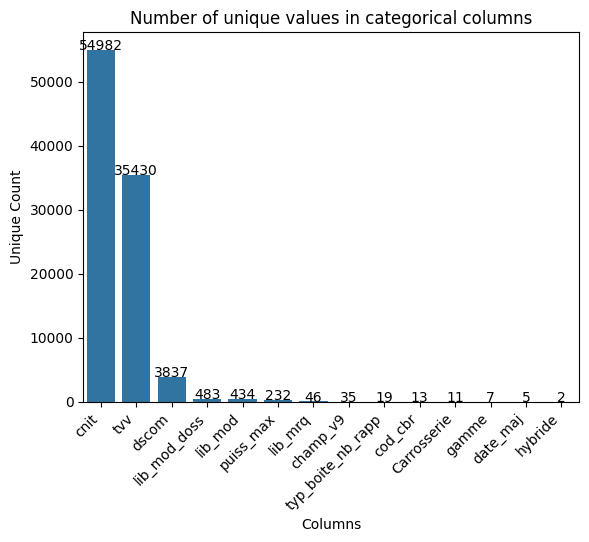

Beginning imputation...
Imputation complete, doing last steps...


In [5]:
tracker = EmissionsTracker(log_level="critical")
tracker.start()


class CustomFeature:
    """
    This class provides custom feature engineering functions for data preprocessing.
    """

    def __init__(self):
        """
        Initializes the CustomFeature object.
        """
        self.map_hybrid = {"non": 0.0, "oui": 1.0}
        self.map_carrosserie = {
            "MINIBUS": 0,
            "BERLINE": 1,
            "BREAK": 2,
            "TS TERRAINS/CHEMINS": 3,
            "COUPE": 4,
            "MONOSPACE": 5,
            "CABRIOLET": 6,
        }

    def plot_bar(self, data: pd.DataFrame) -> None:
        """
        Plots a bar chart showing the number of unique values in categorical columns.

        Args:
            data (pd.DataFrame): The input data.

        Returns:
            None
        """
        ax = sns.barplot(x="Column", y="Modalité", data=data)
        plt.title("Number of unique values in categorical columns")
        plt.xlabel("Columns")
        plt.ylabel("Unique Count")
        plt.xticks(rotation=45, ha="right")
        for index, row in data.iterrows():
            ax.text(index, row["Modalité"], row["Modalité"], ha="center")
        plt.show()

    def countplot_categorical_ftr(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Counts the number of unique values in categorical columns and plots a bar chart.

        Args:
            data (pd.DataFrame): The input data.

        Returns:
            pd.DataFrame: A DataFrame containing the column names and their corresponding unique counts.
        """
        counts = []
        for column in data.columns:
            if not pd.api.types.is_numeric_dtype(data[column]):
                unique_count = data[column].nunique()
                counts.append((column, unique_count))
        counts_df = (
            pd.DataFrame(counts, columns=["Column", "Modalité"])
            .sort_values(by="Modalité", ascending=False)
            .reset_index()
        )
        self.plot_bar(counts_df)
        return counts_df

    def get_number_of_ch(self, data: pd.DataFrame, column: str) -> pd.DataFrame:
        """
        Extracts the number of 'ch' from a text column and adds it as a new column 'CH' in the DataFrame.

        Args:
            data (pd.DataFrame): The input data.
            column (str): The name of the column containing the text.

        Returns:
            pd.DataFrame: The updated DataFrame with the new 'CH' column.
        """
        pattern = r"(\d+)\s*ch"
        data["CH"] = [
            re.findall(pattern, text)[0] if re.findall(pattern, text) else None
            for text in data[column]
        ]
        return data

    def get_norme_euro(self, data: pd.DataFrame, column: str) -> pd.DataFrame:
        """
        Extracts the 'NORME_EURO' from a text column and adds it as a new column in the DataFrame.

        Args:
            data (pd.DataFrame): The input data.
            column (str): The name of the column containing the text.

        Returns:
            pd.DataFrame: The updated DataFrame with the new 'NORME_EURO' column.
        """
        tmp_champv9 = data[column].fillna(value="")
        data["NORME_EURO"] = [
            text[-5:] if "EURO" in text else None for text in tmp_champv9
        ]
        replace_euros = [None, "2EURO"]
        df["NORME_EURO"] = data["NORME_EURO"].replace(replace_euros, "MANQUANT")
        return data

    def encode_hybride_col(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Encodes the 'hybride' column using a predefined mapping.

        Args:
            data (pd.DataFrame): The input data.

        Returns:
            pd.DataFrame: The updated DataFrame with the encoded 'hybride' column.
        """
        data["hybride"] = data["hybride"].map(self.map_hybrid)
        return data

    def build_target_col(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Builds the 'TARGET' column based on the 'Carrosserie' column using a predefined mapping.

        Args:
            data (pd.DataFrame): The input data.

        Returns:
            pd.DataFrame: The updated DataFrame with the 'TARGET' column.
        """
        values_to_replace = [
            "MONOSPACE COMPACT",
            "COMBISPACE",
            "MONOSPACE",
            "COMBISPCACE",
            "MINISPACE",
        ]
        data["Carrosserie"] = data["Carrosserie"].replace(
            values_to_replace, "MONOSPACE"
        )
        data["TARGET"] = data["Carrosserie"].map(self.map_carrosserie)
        data.drop("Carrosserie", axis=1, inplace=True)
        return data

    def knn_impute(
        self, n_neighbors: int, data: pd.DataFrame, cols_to_impute: List[str]
    ) -> pd.DataFrame:
        """
        Performs KNN imputation on the specified columns.

        Args:
            n_neighbors (int): The number of neighbors to consider for imputation.
            data (pd.DataFrame): The input data.
            cols_to_impute (list): A list of column names to impute.

        Returns:
            pd.DataFrame: The updated DataFrame with the imputed values.
        """
        imputer = KNNImputer(n_neighbors=n_neighbors)
        imputed_values = imputer.fit_transform(df[cols_to_impute])
        for i in range(len(cols_to_impute)):
            data[f"imputed_{cols_to_impute[i]}"] = [
                imputed_values[k][i] for k in range(len(imputed_values))
            ]
        data.drop(cols_to_impute, axis=1, inplace=True)
        return data

    def easy_impute(self, data: pd.DataFrame, strategy: str, cols_to_impute):
        """
        Performs simple imputation on the specified columns using the specified strategy.

        Args:
            data (pd.DataFrame): The input data.
            strategy (str): The imputation strategy to use.
            cols_to_impute (list): A list of column names to impute.

        Returns:
            pd.DataFrame: The updated DataFrame with the imputed values.
        """
        imputer = SimpleImputer(strategy=strategy)
        for col in cols_to_impute:
            data[col] = imputer.fit_transform(data[[col]])
        return data

    def drop_unused_cols(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Drops unused columns from the DataFrame.

        Args:
            data (pd.DataFrame): The input data.

        Returns:
            pd.DataFrame: The updated DataFrame with the unused columns dropped.
        """
        data.drop(
            [
                "hc",
                "date_maj",
                "lib_mrq",
                "lib_mod_doss",
                "lib_mod",
                "dscom",
                "cnit",
                "tvv",
                "champ_v9",
            ],
            axis=1,
            inplace=True,
        )
        data.drop(["CH", "typ_boite_nb_rapp"], axis=1, inplace=True)
        data.drop(["conso_exurb", "conso_mixte"], axis=1, inplace=True)
        data.drop("cod_cbr", axis=1, inplace=True)
        return data

    def encode_col(self, data: pd.DataFrame, col: str) -> pd.DataFrame:
        """
        Encodes a categorical column using one-hot encoding.

        Args:
            data (pd.DataFrame): The input data.
            col (str): The name of the column to encode.

        Returns:
            pd.DataFrame: The updated DataFrame with the encoded column.
        """
        df["is_GO"] = df["cod_cbr"].apply(lambda x: 1 if x == "GO" else 0)
        dummies = pd.get_dummies(data[col], prefix=col, dtype=int, drop_first=True)
        data = data.join(dummies)
        joined_data = data.drop("gamme", axis=1)
        return joined_data


simulation = CustomFeature()

simulation.countplot_categorical_ftr(
    df
)  # Countplot of unique values in categorical columns
df = simulation.get_number_of_ch(df, "dscom")  # Extract number of 'ch' from text column
df = simulation.get_norme_euro(df, "champ_v9")  # Extract 'NORME_EURO' from text column
df = simulation.encode_hybride_col(df)  # Encode 'hybride' column
impute_cols = [
    "conso_urb",
    "co2",
    "co_typ_1",
    "hcnox",
    "ptcl",
    "nox",
]  # Columns to impute
print("Beginning imputation...")
df["puiss_max"] = [float(x.replace(",", ".")) for x in df["puiss_max"]]

# df_imputed = simulation.knn_impute(n_neighbors=2, data=df, cols_to_impute=impute_cols) # KNN imputation
print("Imputation complete, doing last steps...")
df = simulation.encode_col(df, "gamme")  # One-hot encoding
df = simulation.drop_unused_cols(df)  # Drop unused columns
df = simulation.build_target_col(df)  # Build target column
impute_emissions = tracker.stop()  # Stop tracking emissions

In [6]:
# grouped = df.groupby('Carrosserie')['imputed_co2'].median()
# grouped.plot(kind='bar')
# plt.xlabel('Carrosserie')
# plt.ylabel('CO2')
# plt.title('Average CO2 Emissions by Carrosserie')

# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=df, x='Carrosserie', y='imputed_co2', palette='Set1', s=100)
# plt.xlabel('Row Index')
# plt.ylabel('CO2 Emissions')
# plt.title('CO2 Emissions by Carrosserie')
# plt.legend(title='Carrosserie')
# plt.tight_layout()

# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=df, x='hcnox', y='imputed_co2', hue='Carrosserie', palette='Set1', s=75)
# plt.xlabel('Hcnox')
# plt.ylabel('CO2 Emissions')
# plt.title('CO2 Emissions by Carrosserie')
# plt.legend(title='Carrosserie')
# plt.tight_layout()
# plt.show()

@Camille libre à toi de modifier la structure de la classe
j'ai créé une méthode random_search_CV() pour créer le corps de la fonction
je pense qu'on peut rajouter aussi une fonction qui comme dans ton notebook, va aller chercher tous nos modèles et établir un graph sur les perfs en tests vs sur la consommation globale training+inférence 

@All, des retours ? 

In [ ]:
df.drop(["NORME_EURO", "hybride"], axis=1, inplace=True)

In [25]:
class pipeline_profiler:
    def __init__(
        self,
        data: pd.DataFrame,
        target: str,
        model: Optional[sklearn.base.BaseEstimator] = None,
        preprocessor: Optional[sklearn.pipeline.Pipeline] = None,
        search_method: str = "none",
        param_grid: Optional[Dict] = None,
        imputer: Optional[
            Union[sklearn.impute.SimpleImputer, sklearn.impute.KNNImputer]
        ] = None,
        cols_to_impute: Optional[List[str]] = None,
    ):
        """
        Initializes the pipeline_profiler object.

        Args:
            data (pd.DataFrame): The input data.
            target (str): The target column name.
            model (Optional[sklearn.base.BaseEstimator], optional): The model to use. Defaults to None.
            preprocessor (Optional[sklearn.pipeline.Pipeline], optional): The preprocessor to use. Defaults to None.
            search_method (str, optional): The search method to use. Defaults to 'grid'.
            param_grid (Optional[Dict], optional): The parameter grid to use. Defaults to None.
            imputer (Optional[Union[sklearn.impute.SimpleImputer, sklearn.impute.KNNImputer]], optional): The imputer to use. Defaults to None.
            cols_to_impute (Optional[List[str]], optional): The columns to impute. Defaults to None.
        """
        self.original_data = data
        self.target = target
        self.model = model
        self.preprocessor = preprocessor
        self.imputer = imputer
        self.cols_to_impute = cols_to_impute
        self._validate_imputer_and_cols_to_impute()
        self.search_method = search_method
        self.param_grid = param_grid
        self._validate_search_method_and_param_grid()
        self.results = {}
        self.imputed = False
        self.fitted = False
        self.splitted = False

    def _validate_imputer_and_cols_to_impute(self):
        if self.imputer is not None and self.cols_to_impute is None:
            raise ValueError(
                "Please provide the columns to impute or remove the imputer."
            )

        if self.cols_to_impute is not None and self.imputer is None:
            print("WARNING: Columns to impute provided but no imputer set.")

        missing_columns = [
            col for col in self.cols_to_impute if col not in self.original_data
        ]
        if self.cols_to_impute is not None and missing_columns:
            raise ValueError(f"Columns {', '.join(missing_columns)} not found in data.")

    def _validate_search_method_and_param_grid(self):
        if self.search_method not in ["grid", "random", "none"]:
            raise ValueError(
                'Invalid search method. Please use "grid", "random", or "none".'
            )
        if self.search_method != "none" and self.param_grid is None:
            raise ValueError(
                "Please provide a parameter grid for grid or random search."
            )
        if self.search_method == "none" and self.param_grid is not None:
            print("WARNING: Parameter grid provided but search method is set to none.")

    def impute_data(self, strategy: str = "mean") -> None:
        """
        Imputes missing values in the specified columns using the specified strategy.

        Args:
            strategy (str, optional): The imputation strategy to use. Defaults to 'mean'.
        """
        self.data = self.original_data.copy()
        if self.imputer is None:
            self.impute_emissions = 0
            return
        else:
            tracker = EmissionsTracker(log_level="critical", save_to_file=False)
            tracker.start()
            self.data[self.cols_to_impute] = self.imputer.fit_transform(
                self.data[self.cols_to_impute]
            )
            self.impute_emissions = tracker.stop() * 1000
        self.imputed = True

    def split_data(self, test_size: float = 0.2) -> None:
        """
        Splits the data into training and testing sets.

        Args:
            test_size (float): The size of the test set.
        """
        tracker = EmissionsTracker(log_level="critical", save_to_file=False)
        tracker.start()

        X = self.data.drop(self.target, axis=1)
        y = self.data[self.target]

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )

        if self.preprocessor is not None:
            X_train = self.preprocessor.fit_transform(X_train)
            X_test = self.preprocessor.transform(X_test)
        self.split_emissions = tracker.stop() * 1000
        self.splitted = True

    def fit(self) -> None:
        """
        Fits the model to the training data.
        """
        if self.fitted == True:
            print("Model already fitted.")
        else:
            if self.search_method == "grid":
                search = GridSearchCV(self.model, self.param_grid, cv=5, n_jobs=-1)
            elif self.search_method == "random":
                search = RandomizedSearchCV(
                    self.model, self.param_grid, cv=5, n_jobs=-1
                )
            elif self.search_method == "none" or self.search_method is None:
                search = self.model
            if not self.imputed:
                self.impute_data()
            if not self.splitted:
                self.split_data()

            tracker = EmissionsTracker(log_level="critical", save_to_file=False)
            tracker.start()
            search.fit(self.X_train, self.y_train)
            emissions = tracker.stop() * 1000
            self.results[self.search_method] = {
                "search": search,
                "emissions": emissions,
            }
            self.fitted = True
            self.evaluate()

    def reset(
        self, impute: bool = True, preprocessing: bool = True, fit: bool = True
    ) -> None:
        """
        Resets the pipeline_profiler object.

        Args:
            impute (bool, optional): Whether to reset the imputation. Defaults to True.
            preprocessing (bool, optional): Whether to reset the preprocessing. Defaults to True.
            fit (bool, optional): Whether to reset the fitting. Defaults to True.
        """
        if impute:
            self.imputed = False
            self.splitted = False
            self.fitted = False
            return
        if preprocessing:
            self.splitted = False
            self.fitted = False
            return
        if fit:
            self.fitted = False
            return

    def set_model(self, model: sklearn.base.BaseEstimator) -> None:
        """
        Sets the model to use.

        Args:
            model (sklearn.base.BaseEstimator): The model to use.
        """
        self.model = model
        self.reset(fit=True)

    def set_preprocessor(self, preprocessor: sklearn.pipeline.Pipeline) -> None:
        """
        Sets the preprocessor to use.

        Args:
            preprocessor (sklearn.pipeline.Pipeline): The preprocessor to use.
        """
        self.preprocessor = preprocessor
        self.reset(preprocessing=True)

    def set_imputer(
        self,
        imputer: Union[sklearn.impute.SimpleImputer, sklearn.impute.KNNImputer],
        cols_to_impute: Optional[List[str]] = None,
    ) -> None:
        """
        Sets the imputer to use.

        Args:
            imputer (Union[sklearn.impute.SimpleImputer, sklearn.impute.KNNImputer]): The imputer to use.
        """
        if cols_to_impute is not None:
            self.cols_to_impute = cols_to_impute
        self.imputer = imputer
        self._validate_imputer_and_cols_to_impute()
        self.reset(impute=True)

    def set_param_grid(self, param_grid: Dict) -> None:
        """
        Sets the parameter grid to use.

        Args:
            param_grid (Dict): The parameter grid to use.
        """
        self.param_grid = param_grid
        self._validate_search_method_and_param_grid()
        self.reset(fit=True)

    def set_search_method(
        self, search_method: str, param_grid: Optional[Dict] = None
    ) -> None:
        """
        Sets the search method to use.

        Args:
            search_method (str): The search method to use.
        """
        if param_grid is not None:
            self.param_grid = param_grid
        if search_method not in ["grid", "random", "none"]:
            raise ValueError(
                'Invalid search method. Please use "grid", "random", or "none".'
            )
        self.search_method = search_method
        self._validate_search_method_and_param_grid()
        self.reset(fit=True)

    def evaluate(self, metric: str = "accuracy") -> float:
        """
        Evaluates the model on the test data using the specified metric.

        Args:
            metric (str, optional): The evaluation metric to use. Defaults to 'accuracy'.

        Returns:
            float: The evaluation score.
        """
        if not self.fitted:
            print("Model not fitted yet.")
            return
        if not self.splitted:
            print("Data not preprocessed yet.")
            return

        tracker = EmissionsTracker(log_level="critical", save_to_file=False)
        tracker.start()
        match metric:
            case "accuracy":
                self.results[self.search_method]["score"] = accuracy_score(
                    self.y_test,
                    self.results[self.search_method]["search"].predict(self.X_test),
                )
            case "f1":
                self.results[self.search_method]["score"] = f1_score(
                    self.y_test,
                    self.results[self.search_method]["search"].predict(self.X_test),
                    average="weighted",
                )
            case "r2":
                self.results[self.search_method]["score"] = r2_score(
                    self.y_test,
                    self.results[self.search_method]["search"].predict(self.X_test),
                )
            case _:
                raise ValueError(
                    'Invalid metric. Please use "accuracy", "f1", or "r2".'
                )

        emissions = tracker.stop() * 1000 / len(self.y_test)

        self.results[self.search_method]["test emissions"] = emissions
        return

    def get_pipeline_profile(self) -> Dict:
        """
        Returns the pipeline profile.

        Returns:
            Dict: The pipeline profile.
        """
        if not self.imputed:
            print("Nothing to profile yet.")
        if not self.splitted:
            print("Data not preprocessed yet.")
            print("Data impute emissions =", self.impute_emissions, "gCO2")
            return
        if not self.fitted:
            print("Pipeline not fitted yet.")
            print("Data impute emissions =", self.impute_emissions, "gCO2")
            print("Data split emissions =", self.split_emissions, "gCO2")
            return

        print("----- Training Profile -----")
        print("Data impute emissions =", self.impute_emissions, "gCO2")
        print("Data split emissions =", self.split_emissions, "gCO2")
        for key, value in self.results.items():
            print(f"{key} search emissions =", value["emissions"], "gCO2")
        print("----- Evaluation Profile -----")
        for key, value in self.results.items():
            print(f"{key} test emissions =", value["test emissions"], "gCO2")
            print(f"{key} test score =", value["score"])

    def plot_results(self) -> None:
        """
        Plots the search emissions against the test score.
        """
        if not self.fitted:
            print("Model not fitted yet.")
            return
        search_names = list(self.results.keys())
        search_emissions = [value["emissions"] for value in self.results.values()]
        test_scores = [value["score"] for value in self.results.values()]

        plt.figure(figsize=(10, 6))
        plt.scatter(
            search_emissions, test_scores, c=search_emissions, cmap="RdYlGn_r", s=100
        )
        for i, name in enumerate(search_names):
            plt.text(
                search_emissions[i], test_scores[i], name, fontsize=12, ha="center"
            )

        plt.xlabel("Search Emissions")
        plt.ylabel("Test Score")
        plt.title("Search Emissions vs Test Score")

# Petit test

In [22]:
# df_imputed = df_imputed.drop(['gamme', 'NORME_EURO'], axis=1)

In [23]:
impute_cols

['conso_urb', 'co2', 'co_typ_1', 'hcnox', 'ptcl', 'nox']

In [24]:
Lr_pipeline = pipeline_profiler(
    data=df,
    imputer=SimpleImputer(),
    cols_to_impute=impute_cols,
    target="TARGET",
    model=LogisticRegression(),
    search_method="grid",
    param_grid={"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
)
Lr_pipeline.fit()
Lr_pipeline.set_search_method("none")
Lr_pipeline.fit()
Lr_pipeline.get_pipeline_profile()
Lr_pipeline.plot_results()

/Users/camille.hascoet/Documents/greenai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/camille.hascoet/Documents/greenai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

AttributeError: 'SimpleImputer' object has no attribute '__name__'